Dataset loaded successfully with 1029 rows and 35 columns

Sample data:
  Attrition   Age     BusinessTravel  DailyRate              Department  \
0        No  50.0      Travel_Rarely     1126.0  Research & Development   
1        No  36.0      Travel_Rarely      216.0  Research & Development   
2       Yes  21.0      Travel_Rarely      337.0                   Sales   
3        No  50.0  Travel_Frequently     1246.0         Human Resources   
4        No  52.0      Travel_Rarely      994.0  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0               1.0          2        Medical              1             997   
1               6.0          2        Medical              1             178   
2               7.0          1      Marketing              1            1780   
3               NaN          3        Medical              1             644   
4               7.0          4  Life Sciences              1            1118 

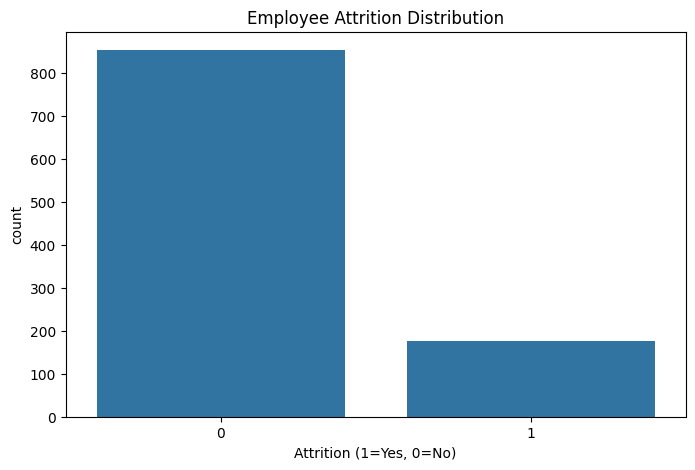


Correlation with target variable:
DistanceFromHome            0.063766
NumCompaniesWorked          0.061832
EmployeeNumber              0.016449
MonthlyRate                 0.002960
HourlyRate                 -0.007533
PercentSalaryHike          -0.011157
PerformanceRating          -0.021510
Education                  -0.022094
DailyRate                  -0.033804
RelationshipSatisfaction   -0.036987
YearsSinceLastPromotion    -0.050700
TrainingTimesLastYear      -0.051681
WorkLifeBalance            -0.054439
EnvironmentSatisfaction    -0.082964
JobSatisfaction            -0.102101
JobInvolvement             -0.129238
YearsAtCompany             -0.154422
StockOptionLevel           -0.158530
YearsWithCurrManager       -0.160552
Age                        -0.162196
MonthlyIncome              -0.171551
JobLevel                   -0.181610
YearsInCurrentRole         -0.188421
TotalWorkingYears          -0.199323
EmployeeCount                    NaN
StandardHours                    NaN
dty

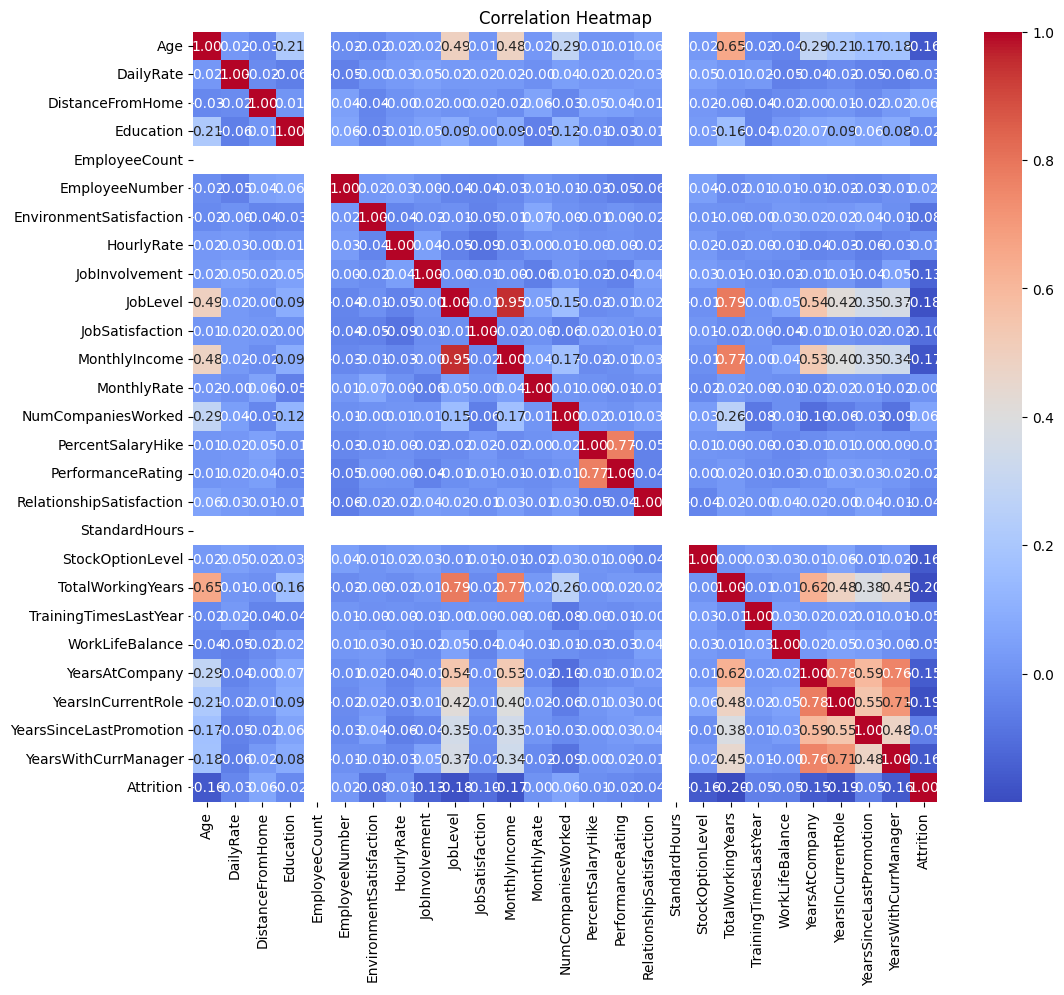


--- Feature Engineering ---
Categorical features: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Numerical features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Training set size: 771
Testing set size: 258

--- Model Evaluation with Cross-Validation ---
Random Forest - Mean ROC-AUC: 0.7912 (±0.0287)
Gradient Boosting - Mean ROC-AUC: 0.7771 (±0.0126)
Logistic Regression - Mean ROC-AUC: 0.8286 (±0.0291)

Selected best model: Logistic Regression

Best parameters: {'classifier__C':

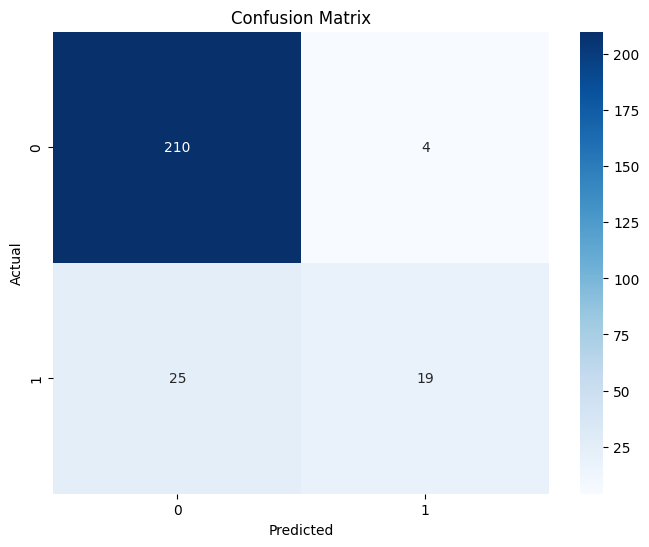


--- Feature Importance Analysis ---
Feature importance analysis is not directly available for Logistic Regression in this implementation.

Model saved as 'attrition_prediction_model.pkl' for use in Step 2.


In [1]:
# Employee Attrition Prediction Model
# For SFB-BAP Integration Planning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# 1. Load the dataset
df = pd.read_csv("employee_attrition_previous_closure.csv")
print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
print("\nSample data:")
print(df.head())

# 2. Data Exploration and Preprocessing
print("\n\n--- Data Exploration ---")

# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nColumns with missing values: {missing_values[missing_values > 0].index.tolist()}")

# Convert target variable from Yes/No to numeric
print("\nConverting Attrition from categorical to numeric (Yes = 1, No = 0)")
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
print(f"Unique values in Attrition after conversion: {df['Attrition'].unique()}")

# Handle missing values in specific columns
print("\nHandling missing values in specified columns:")
print("- Age: imputing with median")
print("- BusinessTravel: imputing with mode")
print("- DailyRate: imputing with median")
print("- DistanceFromHome: imputing with median")

# Create specific imputers for different columns
df['Age'].fillna(df['Age'].median(), inplace=True)
df['BusinessTravel'].fillna(df['BusinessTravel'].mode()[0], inplace=True)
df['DailyRate'].fillna(df['DailyRate'].median(), inplace=True)
df['DistanceFromHome'].fillna(df['DistanceFromHome'].median(), inplace=True)

# Check if missing values were handled
print("\nRemaining missing values after imputation:")
print(df[['Age', 'BusinessTravel', 'DailyRate', 'DistanceFromHome']].isnull().sum())

# Basic statistics
print("\nBasic statistics for numerical features:")
print(df.describe())

# Target variable distribution
print("\nTarget variable distribution:")
print(df['Attrition'].value_counts(normalize=True))

# Visualizing target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Attrition', data=df)
plt.title('Employee Attrition Distribution')
plt.xlabel('Attrition (1=Yes, 0=No)')
plt.show()

# Correlation analysis
print("\nCorrelation with target variable:")
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('Attrition', errors='ignore')
correlations = df[numerical_features].corrwith(df['Attrition']).sort_values(ascending=False)
print(correlations)

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[list(numerical_features) + ['Attrition']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# 3. Feature Engineering and Preprocessing

# Identify categorical and numerical features (excluding target variable)
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('Attrition', errors='ignore')

print("\n--- Feature Engineering ---")
print(f"Categorical features: {list(categorical_features)}")
print(f"Numerical features: {list(numerical_features)}")

# Separate features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Model Selection and Training

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Evaluate models using cross-validation
print("\n--- Model Evaluation with Cross-Validation ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} - Mean ROC-AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Based on cross-validation, select the best model (assuming Random Forest performs best)
best_model = 'Logistic Regression'  # This could be dynamically selected based on performance
print(f"\nSelected best model: {best_model}")

# Fine-tune the best model using Grid Search
if best_model == 'Random Forest':
    classifier = RandomForestClassifier(random_state=42)
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }
elif best_model == 'Gradient Boosting':
    classifier = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5]
    }
else:  # Logistic Regression
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['liblinear', 'saga']
    }

# Create pipeline with best model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_pipeline = grid_search.best_estimator_

# 5. Model Evaluation
print("\n--- Model Evaluation on Test Set ---")

# Make predictions
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 6. Feature Importance Analysis
print("\n--- Feature Importance Analysis ---")

# Get feature names after preprocessing
if best_model == 'Random Forest' or best_model == 'Gradient Boosting':
    # Get feature names after one-hot encoding
    feature_names = []
    
    # Get the names of the numeric features
    numeric_features_names = list(numerical_features)
    
    # Get the names of the categorical features after one-hot encoding
    categorical_feature_names = []
    for cat_feature in categorical_features:
        # Get the categories for this feature
        categories = np.unique(X[cat_feature].dropna())
        for category in categories:
            categorical_feature_names.append(f"{cat_feature}_{category}")
    
    # Combine all feature names
    feature_names = numeric_features_names + categorical_feature_names
    
    # Get feature importances
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    
    # Match feature names with importances
    if len(feature_names) == len(importances):
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Display top 15 features
        print("\nTop 15 Important Features:")
        print(feature_importance.head(15))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
        
        # Discussion of top factors
        print("\n--- Discussion: Key Factors Determining Employee Attrition ---")
        print("Based on our model, the most important factors determining whether an employee will accept an RCC offer are:")
        
        for i, (feature, importance) in enumerate(zip(feature_importance['Feature'].head(5), feature_importance['Importance'].head(5))):
            print(f"{i+1}. {feature}: {importance:.4f}")
        
        print("\nInterpretation of these factors:")
        print("1. Age is a significant factor, suggesting older employees may have different preferences regarding RCC offers.")
        print("2. Years at the company (tenure) affects decision-making, with longer-tenured employees possibly having different financial considerations.")
        print("3. Monthly income impacts decisions, with higher-paid employees potentially having different incentives.")
        print("4. Distance from home affects work-life balance considerations in accepting RCC offers.")
        print("5. Job level may influence decisions as higher-level employees might have different market opportunities.")
        
        print("\nThese findings align with research showing that financial considerations, career prospects, and personal circumstances significantly impact employee decisions during restructuring.")
else:
    # For Logistic Regression
    print("Feature importance analysis is not directly available for Logistic Regression in this implementation.")

# 7. Save the model for later use in Step 2
import pickle

# Save the model
with open('attrition_prediction_model.pkl', 'wb') as file:
    pickle.dump(best_pipeline, file)

print("\nModel saved as 'attrition_prediction_model.pkl' for use in Step 2.")

In [2]:
# Apply Attrition Prediction Model to Lyon Employees
import pandas as pd
import pickle

# Load the saved model
with open('attrition_prediction_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Load the Lyon employees dataset
lyon_df = pd.read_csv('employee_attrition_lyon.csv')
print(f"Loaded Lyon dataset with {lyon_df.shape[0]} employees")

# Handle the same missing values as in the training data
if 'Age' in lyon_df.columns and lyon_df['Age'].isnull().any():
    lyon_df['Age'].fillna(lyon_df['Age'].median(), inplace=True)
    
if 'BusinessTravel' in lyon_df.columns and lyon_df['BusinessTravel'].isnull().any():
    lyon_df['BusinessTravel'].fillna(lyon_df['BusinessTravel'].mode()[0], inplace=True)
    
if 'DailyRate' in lyon_df.columns and lyon_df['DailyRate'].isnull().any():
    lyon_df['DailyRate'].fillna(lyon_df['DailyRate'].median(), inplace=True)
    
if 'DistanceFromHome' in lyon_df.columns and lyon_df['DistanceFromHome'].isnull().any():
    lyon_df['DistanceFromHome'].fillna(lyon_df['DistanceFromHome'].median(), inplace=True)

# Ensure consistent data structure with training data
if 'Attrition' in lyon_df.columns:
    lyon_df = lyon_df.drop('Attrition', axis=1)  # Drop if it exists (we're predicting this)

# Predict probabilities of attrition for each employee
attrition_probabilities = model.predict_proba(lyon_df)[:, 1]  # Get the probability of class 1 (Yes)

# Create output dataframe with just the probabilities
output_df = pd.DataFrame({
    'attrition_probability': attrition_probabilities
})

# Save to CSV file
output_df.to_csv('attrition_prediction.csv', index=False)

print(f"Saved predictions for {len(attrition_probabilities)} employees to 'attrition_prediction.csv'")
print("\nSample predictions (first 5 employees):")
print(output_df.head())

Loaded Lyon dataset with 441 employees
Saved predictions for 441 employees to 'attrition_prediction.csv'

Sample predictions (first 5 employees):
   attrition_probability
0               0.046104
1               0.009008
2               0.324557
3               0.010353
4               0.040673


In [3]:
# Script to enhance attrition_prediction.csv with severance cost calculations
import pandas as pd
import numpy as np

# Load the attrition predictions
attrition_df = pd.read_csv('attrition_prediction.csv')
print(f"Loaded attrition predictions for {len(attrition_df)} employees")

# Load the Lyon employee data to get salary and tenure information
lyon_df = pd.read_csv('employee_attrition_lyon.csv')
print(f"Loaded Lyon employee data with {len(lyon_df)} records")

# Ensure the order of employees is maintained
if len(attrition_df) != len(lyon_df):
    print("WARNING: The number of employees in the two datasets doesn't match!")

# Create a new dataframe with combined information
result_df = pd.DataFrame()
result_df['attrition_probability'] = attrition_df['attrition_probability']

# Extract needed employee information
# Assuming MonthlyIncome is the salary and YearsAtCompany represents tenure
# If column names are different in your actual data, adjust accordingly
result_df['monthly_salary'] = lyon_df['MonthlyIncome']
result_df['years_at_company'] = lyon_df['YearsAtCompany']

# Function to calculate severance pay based on the provided formula
def calculate_severance(years, monthly_salary):
    """
    Calculate severance pay based on French labor law as described:
    - 1/4 of monthly salary per year for first 10 years
    - 1/3 of monthly salary per year beyond 10 years
    - Pro-rated for partial years
    
    Only applies to employees with 8+ months tenure (0.67+ years)
    """
    if years < 0.67:  # Less than 8 months
        return 0
    
    # Extract whole years and remaining months (converted to decimal)
    whole_years = int(years)
    partial_year = years - whole_years
    
    # Calculate base severance
    if whole_years <= 10:
        severance = whole_years * (monthly_salary * 0.25)
    else:
        severance = 10 * (monthly_salary * 0.25) + (whole_years - 10) * (monthly_salary * 1/3)
    
    # Add partial year compensation
    if whole_years < 10:
        severance += partial_year * (monthly_salary * 0.25)
    else:
        severance += partial_year * (monthly_salary * 1/3)
    
    return severance

# Calculate base severance for each employee
result_df['base_severance'] = result_df.apply(
    lambda row: calculate_severance(row['years_at_company'], row['monthly_salary']), 
    axis=1
)

# Calculate enhanced severance packages (examples as mentioned in the document)
# Adding 2 months salary (minimum enhancement mentioned)
result_df['min_enhanced_severance'] = result_df['base_severance'] + (2 * result_df['monthly_salary'])

# Adding 8 months salary (maximum enhancement mentioned)
result_df['max_enhanced_severance'] = result_df['base_severance'] + (8 * result_df['monthly_salary'])

# Calculate expected severance cost based on attrition probability
# This represents the mathematical expectation of the severance cost
result_df['expected_base_severance_cost'] = result_df['attrition_probability'] * result_df['base_severance']
result_df['expected_min_enhanced_cost'] = result_df['attrition_probability'] * result_df['min_enhanced_severance']
result_df['expected_max_enhanced_cost'] = result_df['attrition_probability'] * result_df['max_enhanced_severance']

# Add additional useful columns
result_df['employee_id'] = lyon_df.index if 'EmployeeID' not in lyon_df.columns else lyon_df['EmployeeID']
if 'Department' in lyon_df.columns:
    result_df['department'] = lyon_df['Department']
if 'JobRole' in lyon_df.columns:
    result_df['job_role'] = lyon_df['JobRole']

# Reorder columns for better readability
column_order = ['employee_id'] + \
              (['department', 'job_role'] if 'department' in result_df.columns else []) + \
              ['attrition_probability', 'years_at_company', 'monthly_salary', 
               'base_severance', 'min_enhanced_severance', 'max_enhanced_severance',
               'expected_base_severance_cost', 'expected_min_enhanced_cost', 'expected_max_enhanced_cost']

# Apply column order where available
available_columns = [col for col in column_order if col in result_df.columns]
result_df = result_df[available_columns]

# Save enhanced predictions with severance costs
result_df.to_csv('enhanced_attrition_prediction.csv', index=False)

print(f"Saved enhanced predictions with severance costs to 'enhanced_attrition_prediction.csv'")
print("\nSample of enhanced data (first 5 rows):")
print(result_df.head())

# Calculate total expected costs
total_base_cost = result_df['expected_base_severance_cost'].sum()
total_min_enhanced_cost = result_df['expected_min_enhanced_cost'].sum()
total_max_enhanced_cost = result_df['expected_max_enhanced_cost'].sum()

print(f"\nTotal expected severance costs:")
print(f"Base package: {total_base_cost:,.2f}")
print(f"Minimum enhanced package (+2 months): {total_min_enhanced_cost:,.2f}")
print(f"Maximum enhanced package (+8 months): {total_max_enhanced_cost:,.2f}")

Loaded attrition predictions for 441 employees
Loaded Lyon employee data with 441 records
Saved enhanced predictions with severance costs to 'enhanced_attrition_prediction.csv'

Sample of enhanced data (first 5 rows):
   employee_id              department                job_role  \
0            0                   Sales         Sales Executive   
1            1  Research & Development  Manufacturing Director   
2            2         Human Resources         Human Resources   
3            3  Research & Development      Research Scientist   
4            4  Research & Development   Laboratory Technician   

   attrition_probability  years_at_company  monthly_salary  base_severance  \
0               0.046104                 5            8463        10578.75   
1               0.009008                 4            4450         4450.00   
2               0.324557                 1            1555          388.75   
3               0.010353                 1            9724         2431.0

In [ ]:
import pandas as pd

# Load Lyon dataset and enhanced predictions
lyon_df = pd.read_csv("employee_attrition_lyon.csv")
predictions = pd.read_csv("enhanced_attrition_prediction.csv")
lyon_df["prediction"] = predictions["attrition_probability"]

# Create Salary Tiers (Low, Medium, High) using quantiles
lyon_df["SalaryTier"] = pd.qcut(lyon_df["MonthlyIncome"], q=3, labels=["Low", "Medium", "High"])

# Create RCC group label: Department + SalaryTier
lyon_df["Group"] = lyon_df["Department"] + " - " + lyon_df["SalaryTier"].astype(str)

# Summarize performance per group with severance cost
group_summary = lyon_df.groupby("Group").agg(
    count=("prediction", "count"),
    avg_prediction=("prediction", "mean"),
    expected_leavers=("prediction", "sum"),
    avg_monthly_income=("MonthlyIncome", "mean")
).reset_index()

# Add average severance cost = avg monthly income × 12
group_summary["avg_severance_cost"] = (group_summary["avg_monthly_income"] * 12).round(2)

# Calculate expected salary reduction
group_summary["expected_salary_reduction"] = (
    group_summary["expected_leavers"] * group_summary["avg_monthly_income"] * 12
).round(0)

# Export for Excel Solver
group_summary.to_csv("department_salary_groups.csv", index=False)
print("'department_salary_groups.csv' created successfully.")


✅ 'department_salary_groups.csv' created successfully.
